In [1]:
from fastai.vision.all import *
from fastai.learner import *
from fastai.data.all import *
from fastai.callback.tracker import SaveModelCallback
import pandas as pd
import matplotlib.pyplot as plt
from pathlib2 import Path
import numpy as np
import random
from torch.nn import MSELoss

In [2]:
%%time

df = pd.read_csv('data/examples_with_length_speech2vec_vocab.csv')
df.shape

CPU times: user 17.8 s, sys: 2.29 s, total: 20.1 s
Wall time: 20.1 s


(14276908, 11)

In [3]:
# %%time
# fn2features = pd.read_pickle('data/fn2feature.pkl')

CPU times: user 17.7 s, sys: 15.4 s, total: 33 s
Wall time: 2min 16s


In [4]:
# def prepare_features(fn, pad_to=70, pad_left=False):
#     ary = fn2features[fn][:pad_to]
#     example = np.zeros((pad_to, 13))
#     if pad_left:
#         example[-ary.shape[0]:, :] = ary
#     else: example[:ary.shape[0], :] = ary
#     return example.astype(np.float32)

In [5]:
# dataset_mean = -2
# dataset_std = 10

# def normalize_data(ary):
#     return (ary - dataset_mean) / dataset_std

In [6]:
# %%time

# features = []
# for fn in df.target_fn.unique():
#     features.append(normalize_data(prepare_features(fn)))

CPU times: user 50.2 s, sys: 7.08 s, total: 57.3 s
Wall time: 57.3 s


In [7]:
# np.stack(features).mean(), np.stack(features).std()

(-0.0002623361, 1.0108287)

In [6]:
# fn2features_norm = {fn: normalize_data(prepare_features(fn)) for fn, features in fn2features.items()}
# pd.to_pickle(fn2features_norm, 'data/fn2features_norm.pkl')

In [3]:
%%time
fn2features = pd.read_pickle('data/fn2features_norm.pkl')

CPU times: user 12.6 s, sys: 12.9 s, total: 25.5 s
Wall time: 25.5 s


In [4]:
df = df[df.distance_from_target == 1]
df = df[(~df.target_word.isna() & ~df.source_word.isna())]
df = df[df.in_speech2vec_vocab]
df = df[((df.source_length < 71) & (df.target_length < 71) & (df.source_length > 19))]
df.reset_index(inplace=True, drop=True)

In [5]:
words = np.concatenate((df.target_word, df.source_word))
vocab = list(np.unique(words))

In [6]:
def empty_list(): return list()

In [7]:
# %%time

# word2row_idxs = defaultdict(empty_list)

# for idx, row in df.iterrows():
#     word2row_idxs[row.source_word].append(idx)    

# pd.to_pickle(word2row_idxs, 'data/word2row_idxs_speech2vec_vocab_min_length_20_max_length_70_only_driect_neighbors.pkl')

In [8]:
word2row_idxs = pd.read_pickle('data/word2row_idxs_speech2vec_vocab_min_length_20_max_length_70_only_driect_neighbors.pkl')
word2index = {word: i for i, word in enumerate(vocab)}

In [9]:
train_examples = df[df.set_name.isin(['train-clean-360', 'train-clean-100', 'dev-clean'])]
valid_examples = df[df.set_name == 'test-clean']

train_examples.reset_index(inplace=True, drop=True)
valid_examples.reset_index(inplace=True, drop=True)

In [10]:
class Dataset():
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, idx):
        source_fn = self.df.source_fn[idx]
        target_word = self.df.target_word[idx]
        return fn2features[source_fn], word2index[target_word]

In [11]:
train_ds = Dataset(train_examples)
valid_ds = Dataset(valid_examples)

len(train_ds), len(valid_ds)

(4131148, 46189)

In [12]:
BS = 2048
NUM_WORKERS = 8

train_dl = DataLoader(train_ds, BS, NUM_WORKERS, shuffle=True)
valid_dl = DataLoader(valid_ds, BS, NUM_WORKERS)

dls = DataLoaders(train_dl, valid_dl)

In [13]:
# Got the following error while training:

# DataLoader worker (pid 2073) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.
# trying the solution I found here: https://github.com/pytorch/pytorch/issues/5040
# which is to execute
!sudo umount /dev/shm/ && sudo mount -t tmpfs -o rw,nosuid,nodev,noexec,relatime,size=50G shm /dev/shm

In [52]:
class Model(Module):
    def __init__(self, hidden_size=25):
        self.return_embeddings = False
        self.hidden_size = hidden_size
        
        self.encoder= nn.LSTM(
            input_size=13,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=0,
            bidirectional=True
        )
        
        self.linear = nn.Linear(2*hidden_size, len(vocab))
            
    def forward(self, source_features):
        _, (embeddings, _) = self.encoder(source_features)        
        embeddings = torch.cat((embeddings[-1], embeddings[-2]), 1)
        
        if self.return_embeddings: return embeddings

        return self.linear(embeddings)

In [53]:
learn = Learner(
    dls.cuda(),
    Model().cuda(),
    loss_func=CrossEntropyLossFlat(),
    opt_func=Adam,
    metrics=[accuracy]
)

In [18]:
learn.fit(380, lr=1e-3, cbs=SaveModelCallback(fname='rnn_encoder', every_epoch=True))

epoch,train_loss,valid_loss,accuracy,time
0,6.228283,6.233029,0.090822,01:20
1,6.187213,6.182320,0.092858,01:20
2,6.122165,6.146394,0.095456,01:20
3,6.101551,6.104962,0.097880,01:20
4,6.015668,6.051614,0.098746,01:19
5,5.981417,6.000491,0.102016,01:20
6,5.943680,5.960091,0.104289,01:20
7,5.899813,5.928865,0.106952,01:19
8,5.867502,5.905166,0.108532,01:20
9,5.834493,5.884362,0.108900,01:21


## Calculate embedding for each unique word in the dataset

In [55]:
learn.load('rnn_encoder_379')

In [19]:
df_unique_utterances = df[df.set_name.isin(['train-clean-360', 'train-clean-100', 'dev-clean'])].drop_duplicates(['source_fn'])
df_unique_utterances.reset_index(drop=True, inplace=True)

all_dl = DataLoader(Dataset(df_unique_utterances), BS, NUM_WORKERS)

In [56]:
%%time

learn.model.return_embeddings = True
learn.model.eval()

all_embeddings = []

with torch.no_grad():    
    for batch in all_dl:
        embeddings = learn.model(batch[0].cuda())
        all_embeddings.append(embeddings.detach().cpu().squeeze(0))

CPU times: user 9.17 s, sys: 5.8 s, total: 15 s
Wall time: 43.8 s


In [57]:
all_embeddings = torch.cat(all_embeddings)
all_embeddings.shape

torch.Size([2568907, 50])

In [26]:
# %%time

# word2row_idxs_unique_utterances = defaultdict(empty_list)

# for idx, row in df_unique_utterances.iterrows():
#     word2row_idxs_unique_utterances[row.source_word].append(idx)
    
# pd.to_pickle(word2row_idxs_unique_utterances, 'word2row_idxs_unique_utterances_speech2vec_vocab_min_length_20_max_length_70_only_driect_neighbors.pkl')

CPU times: user 3min 35s, sys: 216 ms, total: 3min 35s
Wall time: 3min 35s


In [27]:
word2row_idxs_unique_utterances = pd.read_pickle('word2row_idxs_unique_utterances_speech2vec_vocab_min_length_20_max_length_70_only_driect_neighbors.pkl')

In [58]:
word2embedding = {}

for k, v in word2row_idxs_unique_utterances.items():
    word2embedding[k] = all_embeddings[np.array(v)].mean(0).numpy()

In [47]:
# word2embedding_without_nans= {}
# nans_encountered = 0
# for k, v in word2embedding.items():
#     if k in vocab and k == k and (not np.isnan(v.numpy()).any()):
#         word2embedding_without_nans[k] = v.numpy()
#     else: nans_encountered += 1

# print(f'Encountered rows with nan values: {nans_encountered}')

In [59]:
from utils import Embeddings

In [60]:
e = Embeddings(
    np.array(list(word2embedding.values())),
    [w.lower() for w in list(word2embedding.keys())]
)

In [61]:
for w in ['fast', 'lost', 'small', 'true', 'crazy', 'slow']:
    print(f'{w}: {e.nn_words_to(e[w])}')

fast: ['fast', 'finest', 'fairest', 'flashed', 'fist']
lost: ['lost', 'last', 'watched', 'lust', 'lashed']
small: ['small', 'sole', 'slow', 'subtle', 'simple']
true: ['true', 'too', 'term', 'trim', 'toe']
crazy: ['crazy', 'clearly', 'kindly', 'plainly', 'creamy']
slow: ['slow', 'sole', 'swallow', 'swell', 'small']


## Evaluating embeddings using [word-embeddings-benchmarks](https://github.com/kudkudak/word-embeddings-benchmarks)

In [62]:
import logging
from six import iteritems
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999
from web.embeddings import fetch_GloVe
from web.evaluate import evaluate_similarity
from web.embedding import Embedding, Vocabulary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [63]:
tasks = {
    "MEN": fetch_MEN(),
    "WS353": fetch_WS353(),
    "SIMLEX999": fetch_SimLex999()
}

In [64]:
our_embeddings = Embedding(
    Vocabulary([w.lower() for w in list(word2embedding.keys())]),
    np.array(list(word2embedding.values()))
)

speech2vec = KeyedVectors.load_word2vec_format('../speech2vec-pretrained-vectors/speech2vec/50.vec', binary=False) 
speech2vec_embeddings = Embedding(Vocabulary(list(speech2vec.vocab.keys())), speech2vec.vectors)

In [65]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(our_embeddings, data.X, data.y)))

Missing 408 words. Will replace them with mean vector
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:336: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  A = np.vstack(w.get(word, mean_vector) for word in X[:, 0])
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  B = np.vstack(w.get(word, mean_vector) for word in X[:, 1])
Missing 65 words. Will replace them with mean vector
Missing 26 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.0716844503238601
Spearman correlation of scores on WS353 0.14622457454822718
Spearman correlation of scores on SIMLEX999 -0.049484569847091577


In [46]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(speech2vec_embeddings, data.X, data.y)))

Missing 392 words. Will replace them with mean vector
Missing 61 words. Will replace them with mean vector
Missing 24 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.5896756323911225
Spearman correlation of scores on WS353 0.49890235673392536
Spearman correlation of scores on SIMLEX999 0.28202624769092116


## Loss decrease and improvements on semantic tasks as training progresses

In [73]:
%%capture

val_losses, accuracies, task_perf = [], [], []
for i in range(380):
    learn.load(f'rnn_encoder_{i}')
    learn.model.return_embeddings = False
    loss, accuracy = learn.validate()
    val_losses.append(loss)
    accuracies.append(accuracy)
    
    learn.model.return_embeddings = True
    learn.model.eval()

    all_embeddings = []

    with torch.no_grad():    
        for batch in all_dl:
            embeddings = learn.model(batch[0].cuda())
            all_embeddings.append(embeddings.detach().cpu().squeeze(0))

    all_embeddings = torch.cat(all_embeddings)

    word2embedding = {}
    for k, v in word2row_idxs_unique_utterances.items():
        word2embedding[k] = all_embeddings[np.array(v)].mean(0).numpy()

    our_embeddings = Embedding(
        Vocabulary([w.lower() for w in list(word2embedding.keys())]),
        np.array(list(word2embedding.values()))
    )
    task_perf.append([evaluate_similarity(our_embeddings, data.X, data.y) for name, data in iteritems(tasks)])

In [74]:
men, ws353, simlex999 = list(zip(*task_perf))

In [75]:
import matplotlib.pyplot as plt

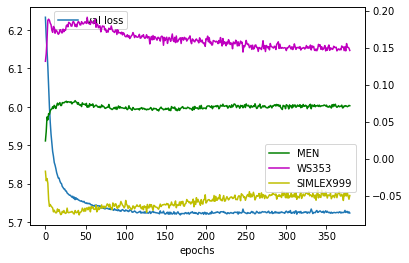

In [76]:
fig, ax1 = plt.subplots()

ax1.plot(val_losses, label='val loss')

ax2 = ax1.twinx()
ax2.plot(men, label='MEN', c='g')
ax2.plot(ws353, label='WS353', c='m')
ax2.plot(simlex999, label='SIMLEX999', c='y')

ax1.legend(loc=[0.07, 0.9])
ax2.legend(loc=[0.7, 0.15])

ax1.set_xlabel('epochs');